In [21]:
import pandas as pd
import chardet
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:

with open('Telemetria_Construserv_2025-09-17_jusante.csv', 'rb') as f:
    result = chardet.detect(f.read())
print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [17]:

df = pd.read_csv('Telemetria_Construserv_2025-09-17_jusante.csv', encoding='ISO-8859-1',
                 sep=';',skiprows=1, skipfooter=1, engine='python', decimal=',',
                na_values = '-')
df

,Unnamed: 0,Precipitação (mm)**,Nível (cm),Vazão (m3/s)
0,20/01/2022 16:00,4.0,55.0,0.00
1,20/01/2022 17:00,0.0,145.0,7.05
2,20/01/2022 18:00,0.0,145.0,7.05
3,20/01/2022 19:00,0.0,145.0,7.05
4,20/01/2022 20:00,0.0,146.0,7.23
...,...,...,...,...
32067,17/09/2025 19:00,NaN,NaN,NaN
32068,17/09/2025 20:00,NaN,NaN,NaN
32069,17/09/2025 21:00,NaN,NaN,NaN
32070,17/09/2025 22:00,NaN,NaN,NaN


In [18]:
df.describe()

,Precipitação (mm)**,Nível (cm),Vazão (m3/s)
count,31906.000000,31906.000000,31906.000000
mean,0.078988,119.337899,3.909092
std,0.771692,24.104387,4.752410
min,0.000000,55.000000,0.000000
25%,0.000000,104.000000,1.900000
50%,0.000000,113.000000,2.570000
75%,0.000000,125.000000,4.000000
max,42.400000,412.000000,107.120000


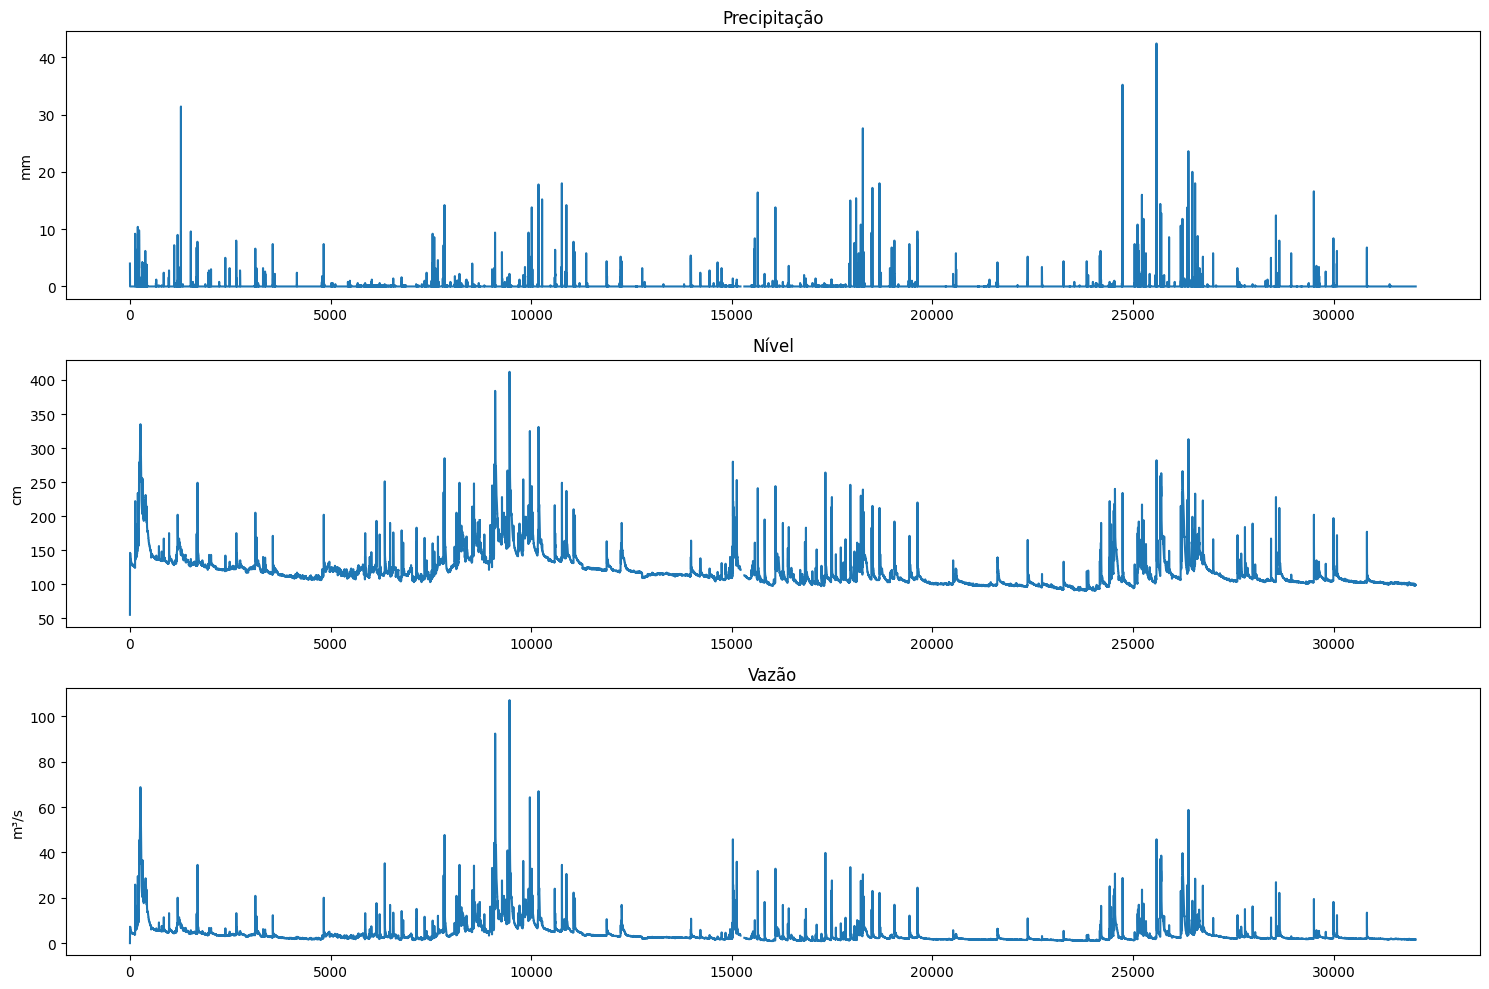

In [20]:

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1) # 3 linhas, 1 coluna, primeiro subplot
df['Precipitação (mm)**'].plot()
plt.title('Precipitação')
plt.ylabel('mm')

plt.subplot(3, 1, 2) # 3 linhas, 1 coluna, segundo subplot
df['Nível (cm)'].plot()
plt.title('Nível')
plt.ylabel('cm')

plt.subplot(3, 1, 3) # 3 linhas, 1 coluna, terceiro subplot
df['Vazão (m3/s)'].plot()
plt.title('Vazão')
plt.ylabel('m³/s')

plt.tight_layout() 
plt.show()

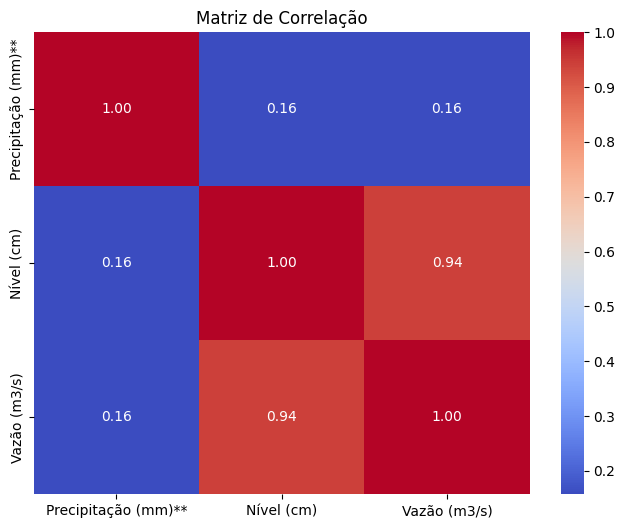

In [22]:

correlation_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(8, 6))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()

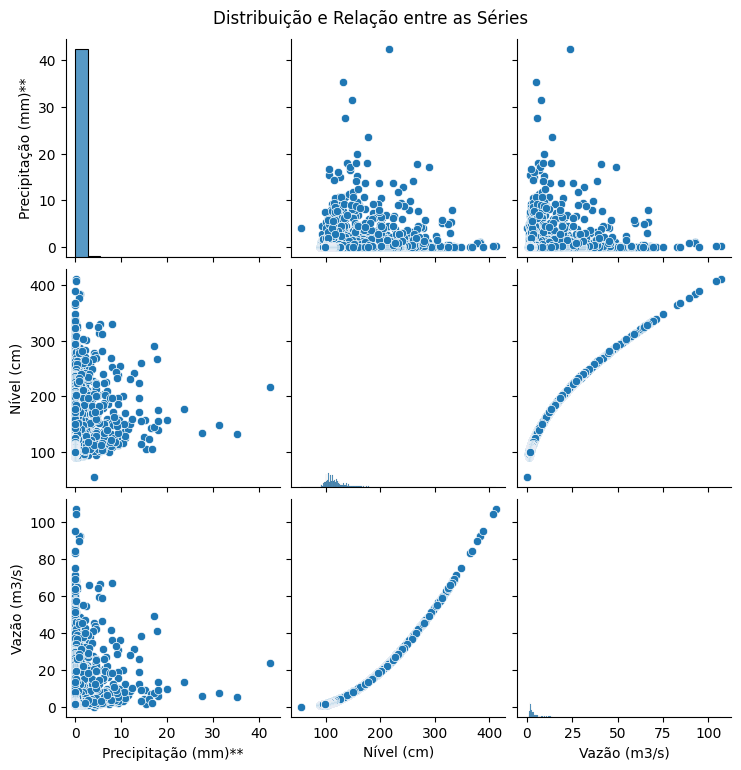

In [23]:
# Cria o pairplot para as colunas de interesse
sns.pairplot(df[['Precipitação (mm)**', 'Nível (cm)', 'Vazão (m3/s)']])

plt.suptitle('Distribuição e Relação entre as Séries', y=1.02) # Título acima dos plots
plt.show()

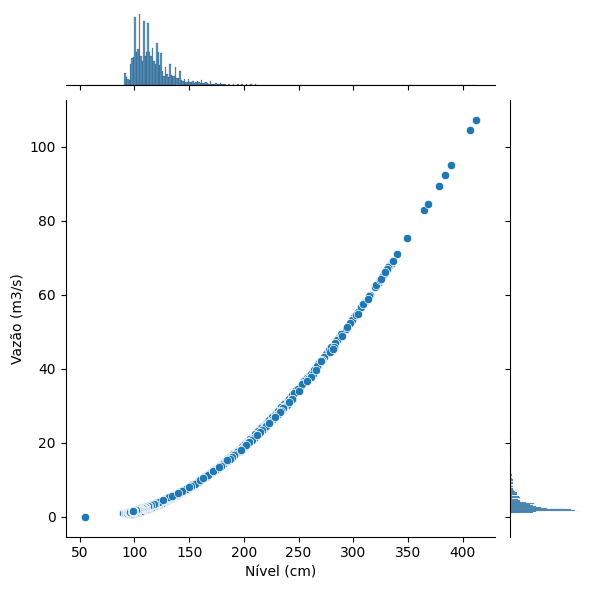

In [24]:
sns.jointplot(data=df, x='Nível (cm)', y='Vazão (m3/s)', kind='scatter')

plt.show()

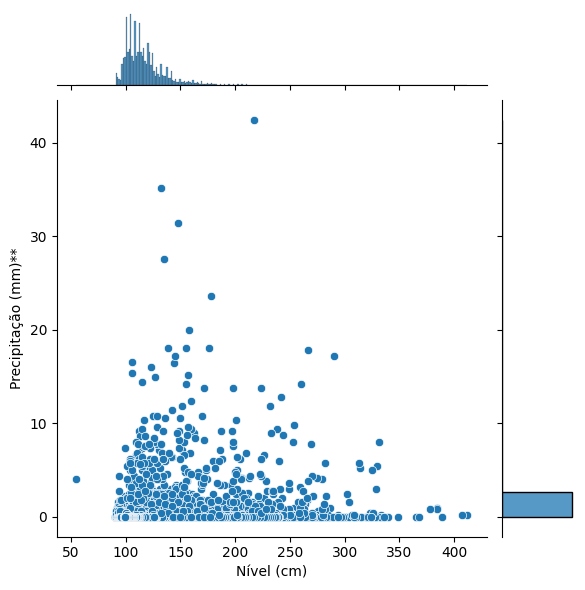

In [25]:
sns.jointplot(data=df, x='Nível (cm)', y='Precipitação (mm)**', kind='scatter')

plt.show()